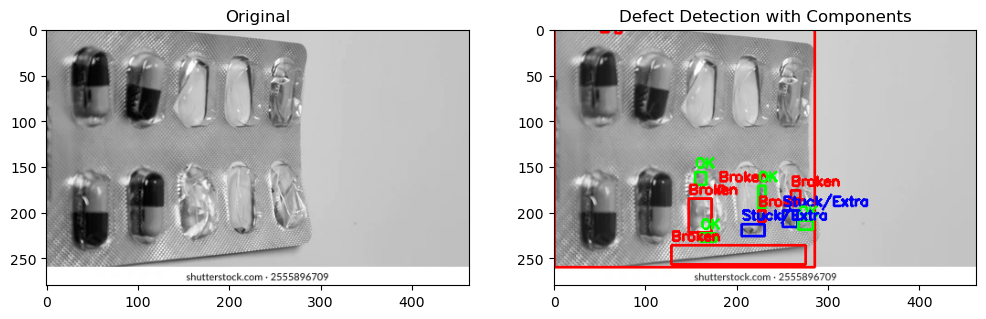

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("image.png", cv2.IMREAD_GRAYSCALE)

blur = cv2.GaussianBlur(img, (5,5), 0)


_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

if np.sum(thresh == 255) > np.sum(thresh == 0):
    thresh = cv2.bitwise_not(thresh)

kernel = np.ones((3,3), np.uint8)
clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(clean, connectivity=8)

output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

areas = stats[1:, cv2.CC_STAT_AREA]   
normal_area = np.median(areas)

for i in range(1, num_labels): 
    x, y, w, h, area = stats[i]

    component_mask = (labels == i).astype("uint8") * 255
    contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours: 
        continue
    
    perimeter = cv2.arcLength(contours[0], True)
    circularity = 4 * np.pi * area / (perimeter * perimeter + 1e-6)
    aspect_ratio = w / float(h)

    if area < 0.7 * normal_area or circularity < 0.5:
        color = (0,0,255)    
        label = "Broken"
    elif area > 1.5 * normal_area:
        color = (255,0,0)      
        label = "Stuck/Extra"
    else:
        color = (0,255,0)      
        label = "OK"

    cv2.rectangle(output, (x,y), (x+w, y+h), color, 2)
    cv2.putText(output, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(output[:,:,::-1])
plt.title("Defect Detection with Components")

plt.show()